# Synthetic Warranty Claim Judge — Rule-based + ML Pipeline

**Author:** Gabriel Alves  
**Status:** Portfolio demo (synthetic data, no real customer information)

This notebook implements an end-to-end warranty claim decision pipeline:

1. Configuration and parameters  
2. Synthetic data generation (claims table)  
3. Data cleaning and feature engineering  
4. Rule-based and ML-based decision engine  
5. Evaluation and explainability  
6. Export of scored claims for downstream use

All data here is synthetic and only mimics typical patterns seen in warranty analytics projects.


In [1]:
# ============================================================
# 0. IMPORTS
# ============================================================

import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)

# Ensure project root on PYTHONPATH (so we can import from pipeline/)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from pipeline.synthetic_data import generate_synthetic_warranty_data

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)


In [2]:
# ============================================================
# 1. CONFIGURATION
# ============================================================

# "As-of" date for this run (synthetic)
RUN_DATE = "2025-11-01"
run_date_ts = pd.to_datetime(RUN_DATE)

# Number of synthetic claims to generate
N_ROWS = 5000

# Target configuration
TARGET_COL = "Final_Claim_Decision"
POSITIVE_CLASS = "Approve"

# Paths (relative to project root)
RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV_PATH = RAW_DIR / "warranty_claims_synthetic.csv"
PROCESSED_CSV_PATH = PROCESSED_DIR / "warranty_claims_processed.csv"
SCORED_CSV_PATH = PROCESSED_DIR / "warranty_claims_scored.csv"

RUN_DATE, RAW_CSV_PATH, PROCESSED_CSV_PATH, SCORED_CSV_PATH


('2025-11-01',
 WindowsPath('../data/raw/warranty_claims_synthetic.csv'),
 WindowsPath('../data/processed/warranty_claims_processed.csv'),
 WindowsPath('../data/processed/warranty_claims_scored.csv'))

In [3]:
# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived features analogous to what you would find in a
    production warranty pipeline (age, delay, etc.).
    """
    df = df.copy()

    # Parse dates
    for c in ["Claim_Date", "Vehicle_Registration_Date", "Vehicle_Failure_Date"]:
        df[c] = pd.to_datetime(df[c])

    # Vehicle age at claim (years)
    df["Vehicle_Age_Years"] = (
        (df["Claim_Date"] - df["Vehicle_Registration_Date"])
        .dt.days
        .div(365.25)
    ).clip(lower=0)

    # Days from failure to claim
    df["Days_Failure_to_Claim"] = (
        (df["Claim_Date"] - df["Vehicle_Failure_Date"])
        .dt.days
    ).clip(lower=0)

    return df


def apply_simple_rules(df: pd.DataFrame) -> pd.Series:
    """
    Simple rule-based layer to emulate business rules:

    - Very new vehicles, low mileage, and low cost → Approve
    - Very old vehicles, high mileage, very high cost → Reject
    - Otherwise → NoRule (left to model / manual decision)

    Returns a Series with values: "Approve", "Reject", or "NoRule".
    """
    df = df.copy()

    cond_auto_approve = (
        (df["Vehicle_Age_Years"] < 2.0)
        & (df["Mileage_km"] < 30_000)
        & (df["Total_Cost"] < 800)
    )

    cond_auto_reject = (
        (df["Vehicle_Age_Years"] > 8.0)
        & (df["Mileage_km"] > 150_000)
        & (df["Total_Cost"] > 2_500)
    )

    rule_decision = np.where(
        cond_auto_approve, "Approve",
        np.where(cond_auto_reject, "Reject", "NoRule")
    )

    return pd.Series(rule_decision, index=df.index, name="Rule_Decision")


In [4]:
# ============================================================
# 3. DATA GENERATION + BASIC EDA
# ============================================================

# Generate synthetic data in memory
df_raw = generate_synthetic_warranty_data(n_rows=N_ROWS, random_state=42)

# Save raw snapshot (analogous to monthly AI_Results, but local and synthetic)
df_raw.to_csv(RAW_CSV_PATH, index=False)

print("Raw shape:", df_raw.shape)
print("\nTarget distribution:")
print(df_raw[TARGET_COL].value_counts(normalize=True))

df_raw.head()


Raw shape: (5000, 17)

Target distribution:
Final_Claim_Decision
Reject     0.5418
Approve    0.4582
Name: proportion, dtype: float64


,Claim_ID,Claim_Date,Vehicle_Registration_Date,Vehicle_Failure_Date,Vehicle_MFD_Year,Mileage_km,Part_Group,Subpart_Code,Failure_Mode,Customer_Type,Region,Labor_Cost,Material_Cost,Total_Cost,Burden_Ratio,Final_Claim_Decision,Final_DPR_Decision
0,CLM_000001,2022-04-08,2020-06-04,2022-03-19,2020,27512.065570,Chassis,CHS_A,No_Start,Retail,Region_2,154.603156,388.187881,542.791037,0.382099,Approve,Reject
1,CLM_000002,2024-04-27,2023-10-12,2024-04-14,2023,4840.819371,Body,BODY_B,No_Start,Retail,Region_3,142.265157,68.022091,210.287249,0.791511,Approve,Reject
2,CLM_000003,2023-12-18,2018-09-16,2023-11-17,2018,74398.919284,Electronics,ELEC_A,Leak,Retail,Region_2,159.957023,426.241409,586.198432,0.362170,Reject,Reject
3,CLM_000004,2023-04-26,2017-08-15,2023-03-17,2017,58781.129706,Body,BODY_A,Electrical_Issue,Retail,Region_3,278.097472,168.986598,447.084071,0.621667,Approve,Approve
4,CLM_000005,2023-04-20,2016-11-22,2023-04-04,2016,87272.268653,Electronics,ELEC_C,No_Start,Retail,Region_2,226.480249,334.526356,561.006604,0.734220,Reject,Reject


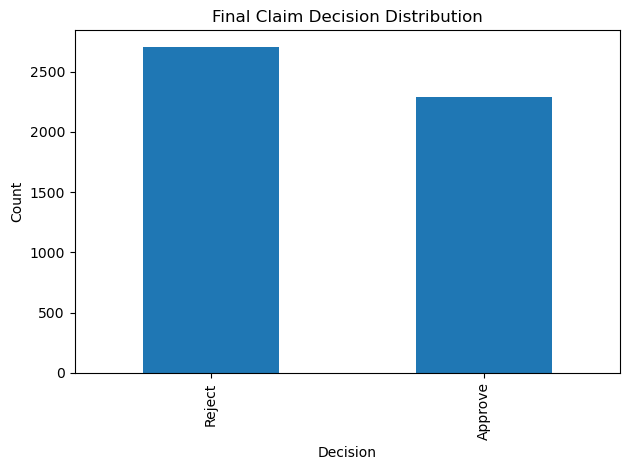

C:\Users\ALG1YH\AppData\Local\Temp\ipykernel_28496\3203876693.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


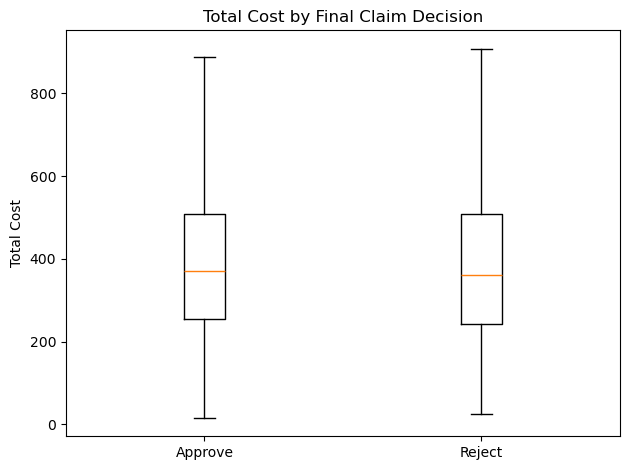

In [5]:
# Class balance
fig, ax = plt.subplots()
df_raw[TARGET_COL].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Final Claim Decision Distribution")
ax.set_xlabel("Decision")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Total cost distribution by decision (boxplot)
fig, ax = plt.subplots()
approve_costs = df_raw.loc[df_raw[TARGET_COL] == "Approve", "Total_Cost"]
reject_costs = df_raw.loc[df_raw[TARGET_COL] == "Reject", "Total_Cost"]

ax.boxplot(
    [approve_costs.values, reject_costs.values],
    labels=["Approve", "Reject"],
    showfliers=False,
)
ax.set_title("Total Cost by Final Claim Decision")
ax.set_ylabel("Total Cost")
plt.tight_layout()
plt.show()


In [6]:
# ============================================================
# 4. CLEANING + FEATURE ENGINEERING
# ============================================================

df = df_raw.copy()

# Ensure numeric types
numeric_base_cols = [
    "Vehicle_MFD_Year",
    "Mileage_km",
    "Labor_Cost",
    "Material_Cost",
    "Total_Cost",
    "Burden_Ratio",
]
df[numeric_base_cols] = df[numeric_base_cols].apply(pd.to_numeric, errors="coerce")

# Categorical columns
cat_cols = [
    "Part_Group",
    "Subpart_Code",
    "Failure_Mode",
    "Customer_Type",
    "Region",
    "Final_Claim_Decision",
    "Final_DPR_Decision",
]
for c in cat_cols:
    df[c] = df[c].astype("category")

# Add engineered features (age, delay)
df = add_engineered_features(df)

# Apply rule-based suggestions
df["Rule_Decision"] = apply_simple_rules(df)

# Save processed snapshot (synthetic analog of validated claims)
df_processed = df.copy()
df_processed.to_csv(PROCESSED_CSV_PATH, index=False)

df_processed.head()


,Claim_ID,Claim_Date,Vehicle_Registration_Date,Vehicle_Failure_Date,Vehicle_MFD_Year,Mileage_km,Part_Group,Subpart_Code,Failure_Mode,Customer_Type,Region,Labor_Cost,Material_Cost,Total_Cost,Burden_Ratio,Final_Claim_Decision,Final_DPR_Decision,Vehicle_Age_Years,Days_Failure_to_Claim,Rule_Decision
0,CLM_000001,2022-04-08,2020-06-04,2022-03-19,2020,27512.065570,Chassis,CHS_A,No_Start,Retail,Region_2,154.603156,388.187881,542.791037,0.382099,Approve,Reject,1.842574,20,Approve
1,CLM_000002,2024-04-27,2023-10-12,2024-04-14,2023,4840.819371,Body,BODY_B,No_Start,Retail,Region_3,142.265157,68.022091,210.287249,0.791511,Approve,Reject,0.542094,13,Approve
2,CLM_000003,2023-12-18,2018-09-16,2023-11-17,2018,74398.919284,Electronics,ELEC_A,Leak,Retail,Region_2,159.957023,426.241409,586.198432,0.362170,Reject,Reject,5.253936,31,NoRule
3,CLM_000004,2023-04-26,2017-08-15,2023-03-17,2017,58781.129706,Body,BODY_A,Electrical_Issue,Retail,Region_3,278.097472,168.986598,447.084071,0.621667,Approve,Approve,5.694730,40,NoRule
4,CLM_000005,2023-04-20,2016-11-22,2023-04-04,2016,87272.268653,Electronics,ELEC_C,No_Start,Retail,Region_2,226.480249,334.526356,561.006604,0.734220,Reject,Reject,6.406571,16,NoRule


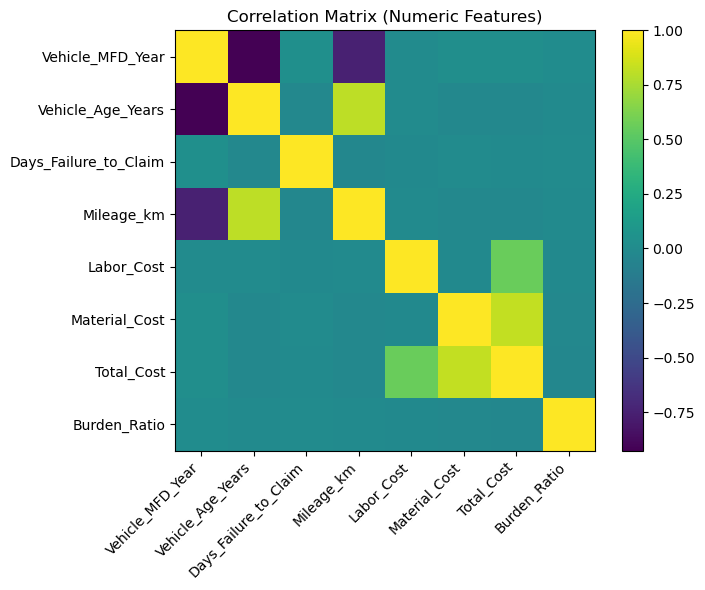

In [7]:
numeric_features = [
    "Vehicle_MFD_Year",
    "Vehicle_Age_Years",
    "Days_Failure_to_Claim",
    "Mileage_km",
    "Labor_Cost",
    "Material_Cost",
    "Total_Cost",
    "Burden_Ratio",
]

corr = df_processed[numeric_features].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(numeric_features)))
ax.set_yticks(range(len(numeric_features)))
ax.set_xticklabels(numeric_features, rotation=45, ha="right")
ax.set_yticklabels(numeric_features)
ax.set_title("Correlation Matrix (Numeric Features)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()




In [8]:
# ============================================================
# 5. MODEL PIPELINE — TRAIN & EVALUATE
# ============================================================

# Final feature set: numeric + categorical
categorical_features = [
    "Part_Group",
    "Subpart_Code",
    "Failure_Mode",
    "Customer_Type",
    "Region",
]

feature_cols = numeric_features + categorical_features

X = df_processed[feature_cols].copy()
y = df_processed[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((3750, 13), (1250, 13))

In [9]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", clf),
    ]
)

model

model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
y_pred = model.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm


Classification report:
              precision    recall  f1-score   support

     Approve       0.60      0.56      0.58       573
      Reject       0.65      0.68      0.66       677

    accuracy                           0.62      1250
   macro avg       0.62      0.62      0.62      1250
weighted avg       0.62      0.62      0.62      1250



array([[323, 250],
       [219, 458]], dtype=int64)

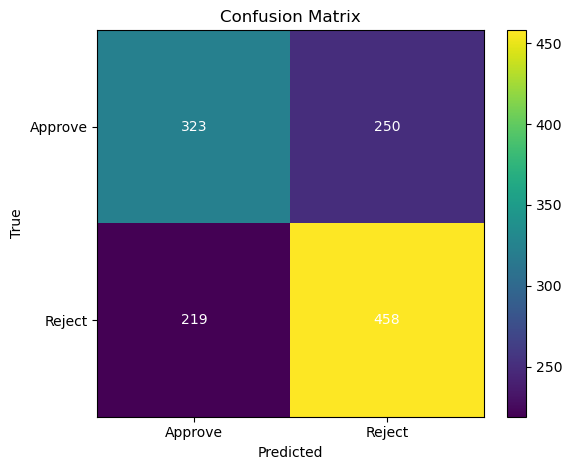

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(model.classes_)
ax.set_yticklabels(model.classes_)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


ROC AUC (Approve vs others): 0.667


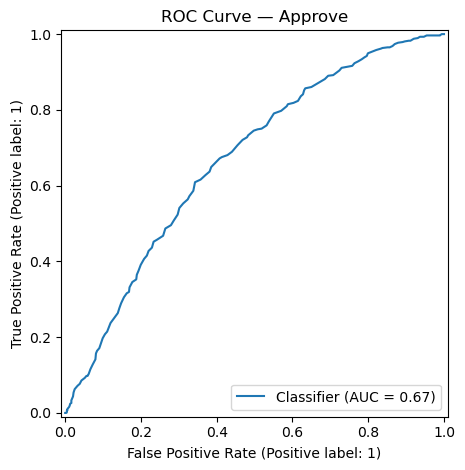

In [12]:
pos_idx = list(model.classes_).index(POSITIVE_CLASS)
y_proba = model.predict_proba(X_test)[:, pos_idx]
y_true_bin = (y_test == POSITIVE_CLASS).astype(int)

roc_auc = roc_auc_score(y_true_bin, y_proba)
print(f"ROC AUC ({POSITIVE_CLASS} vs others): {roc_auc:.3f}")

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_true_bin,
    y_proba,
    ax=ax,
)
ax.set_title(f"ROC Curve — {POSITIVE_CLASS}")
plt.tight_layout()
plt.show()


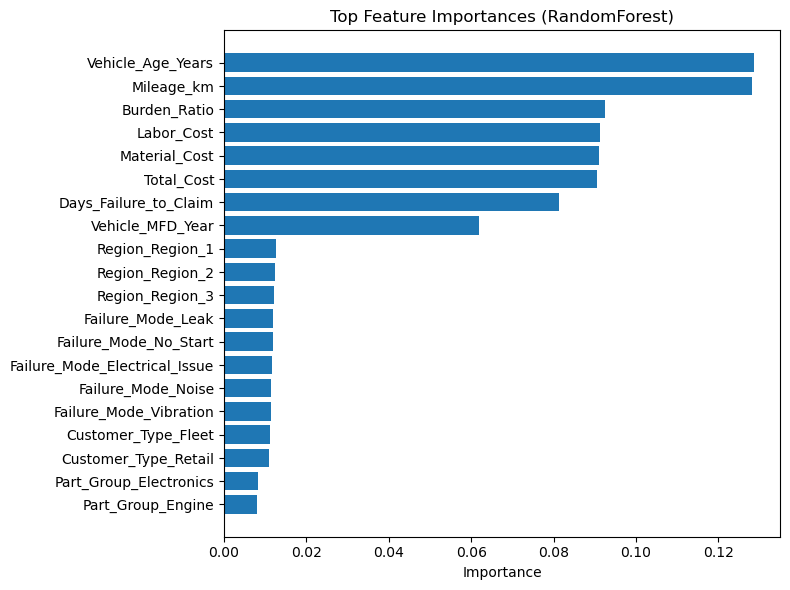

,feature,importance
1,Vehicle_Age_Years,0.128502
3,Mileage_km,0.128092
7,Burden_Ratio,0.092447
4,Labor_Cost,0.091341
5,Material_Cost,0.090963
6,Total_Cost,0.090535
2,Days_Failure_to_Claim,0.081379
0,Vehicle_MFD_Year,0.061983
32,Region_Region_1,0.012719
33,Region_Region_2,0.012286


In [13]:
# Extract feature names after preprocessing
ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = list(ohe.get_feature_names_out(categorical_features))

all_features = numeric_features + ohe_features

rf = model.named_steps["classifier"]
importances = rf.feature_importances_

feat_imp = (
    pd.DataFrame({"feature": all_features, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
ax.set_title("Top Feature Importances (RandomForest)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

feat_imp


In [14]:
# ============================================================
# 6. EXPORT SCORED CLAIMS
# ============================================================

X_test_out = X_test.copy()
X_test_out["Final_Claim_Decision_True"] = y_test.values
X_test_out["Final_Claim_Decision_Pred"] = y_pred
X_test_out["Prob_Approve"] = y_proba

# Attach rule-based suggestion for comparison
X_test_out["Rule_Decision"] = df_processed.loc[X_test_out.index, "Rule_Decision"]

X_test_out.to_csv(SCORED_CSV_PATH, index=False)

SCORED_CSV_PATH, X_test_out.head()


(WindowsPath('../data/processed/warranty_claims_scored.csv'),
       Vehicle_MFD_Year  Vehicle_Age_Years  Days_Failure_to_Claim    Mileage_km  Labor_Cost  Material_Cost  Total_Cost  Burden_Ratio  \
 3412              2020           2.102669                     26  30275.653071  303.765948     299.206191  602.972139      0.558896   
 3442              2020           2.713210                      2  55509.073427  128.746802     205.238514  333.985317      0.570179   
 1053              2022           2.392882                     19  39429.622491  126.873062     323.383919  450.256980      0.564710   
 556               2023           1.078713                     44  15139.046009  562.531405     381.557733  944.089138      0.931369   
 30                2020           2.789870                      4  15949.627623  223.105442     346.281574  569.387016      0.447123   
 
        Part_Group Subpart_Code Failure_Mode Customer_Type    Region Final_Claim_Decision_True Final_Claim_Decision_Pred

## 7. Summary

This notebook implements a full warranty claim decision pipeline on synthetic data:

- Central configuration block for run date, paths, and targets  
- Synthetic claim table generation with realistic structure  
- Cleaning and feature engineering (vehicle age, delay, cost structure)  
- Simple rule-based layer to demonstrate domain logic  
- Supervised model (RandomForest) with:
  - Preprocessing (scaling + one-hot encoding)
  - Metrics (classification report, confusion matrix, ROC AUC)
  - Feature importance overview  
- Export of a scored file suitable for dashboards or further analysis

In a real environment, this pipeline could be:

- Connected to scheduled data refreshes,
- Validated against historical decisions,
- Integrated into BI tools for interactive review of borderline claims,
- Extended with cost-sensitive thresholds and more complex business rules.
